# Point Cloud Binary Classification with PyTorch

Make sure you are using the `dl4cv` conda environment.

## Dataset loading and visualization

The input X contain 100 2D points, and y are their corresponding labels (0 or 1). The goal is to train a model that can classify every point to its correct label.


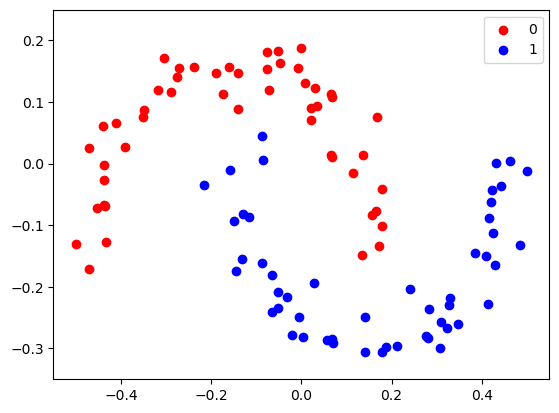

<Figure size 640x480 with 0 Axes>

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam

dataset = np.load('data/2d_pcl_dataset.npz')
X, y = dataset['X'], dataset['y']

X0 = X[y==0] # 50 2D points have label 0
X1 = X[y==1] # 50 2D points have label 1

def plot(X0, X1, fit_param=None):
    plt.scatter(X0[:,0], X0[:,1], color='red', label=0)
    plt.scatter(X1[:,0], X1[:,1], color='blue', label=1)
    
    plt.xlim([-0.55, 0.55])
    plt.ylim([-0.35, 0.25])
    plt.legend()
    plt.show()
    plt.clf()

plot(X0, X1)

## Logistic Regression for the point cloud classification task


Starting by filling in the `Simple2DDataset` class below. First, in the class constructore `__init__`, you will need to read the right `2d_pcl_dataset.npz` from disk.

Second, in the `__getitem__`, you will need to take a single data point and its label based on its index `idx`

In [21]:
class Simple2DDataset(Dataset):
    def __init__(self):
        super().__init__()
        #########################################################################
        # TODO: read data from disk using np.load.
        # Data is located in the folder "data".
        # Save samples and labels to class members self.X and self.y respectively.
        # samples should be an Nx2 numpy array. Labels should be Nx1.
        #########################################################################
        
        labeled_data = np.load("data/2d_pcl_dataset.npz")
        self.X = labeled_data["X"]
        self.y = labeled_data["y"]
        
        assert X.ndim == 2 and X.shape[1] == 2
        assert y.ndim == 1
        assert X.shape[0] == y.shape[0]
     
    def __len__(self):
        # Returns the number of samples in the dataset.
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        #########################################################################
        # TODO: return the sample and label with index idx
        #########################################################################
        point = self.X[idx]
        label = self.y[idx]
        
        # Convert to tensor.
        return torch.from_numpy(point).float(), \
               torch.from_numpy(label[np.newaxis]).float()


With the complete `Simple2DDataset`, we can create a PyTorch dataloader

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [26]:
BATCH_SIZE = 8
NUM_WORKERS = 0

# create the dataloader
dataset = Simple2DDataset()
train_dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

Now, define your first network by filling in the `LinearClassifier` class below.

Add a single linear layer `nn.Linear` inside the `nn.Sequential` call. The input is 2D, and the output should be a single value, corresponding to the probability of a given 2D point being part of cluster 0.

In [27]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.codename = 'linear'

        #########################################################################
        # TODO: add a single linear layer with nn.Linear, inside the `nn.Sequential` call.
        # Input is 2D.
        # Output is a single value.
        #########################################################################
        self.model = nn.Sequential(nn.Linear(2,1))
        
    def forward(self, batch):
        # Process batch using the defined model.
        x = self.model(batch)
        # Final sigmoid activation to obtain a probability between 0 and 1.
        return torch.sigmoid(x)

Now, you are asked to implement the training loop below

In [28]:
def train(net, optimizer, dataloader, epoch):
    net.train()
    loss_sum = 0
    for batch_idx, (point, label) in enumerate(dataloader):
        # First we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()

        #########################################################################
        #TODO: 
        # 1. forward pass of the network to obtain the predictions given the batch
        # 2. compute the loss using F.binary_cross_entropy
        # 3. backward pass on the loss using loss.backward(), and one step 
        # of gradient descent (optimization) using optimizer.step()
        #########################################################################
        
        predictions = net.forward(point)
        loss = F.binary_cross_entropy(predictions, label)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        
    return loss_sum
        

You can now run below to train the linear model.

In [29]:
NUM_EPOCHS = 100
# create the network.
net = LinearClassifier()

# create the optimizer.
optimizer = Adam(net.parameters(), lr=0.1)

best_accuracy = 0
for epoch_idx in range(NUM_EPOCHS):
    loss = train(net, optimizer, train_dataloader, epoch_idx)
    print('[Epoch %02d] Loss: %.4f' % (epoch_idx + 1, loss))

[Epoch 01] Loss: 7.8608
[Epoch 02] Loss: 6.4392
[Epoch 03] Loss: 5.6126
[Epoch 04] Loss: 5.1218
[Epoch 05] Loss: 4.8769
[Epoch 06] Loss: 4.8224
[Epoch 07] Loss: 4.4411
[Epoch 08] Loss: 4.2656
[Epoch 09] Loss: 4.1916
[Epoch 10] Loss: 4.0215
[Epoch 11] Loss: 3.9476
[Epoch 12] Loss: 4.0445
[Epoch 13] Loss: 3.9144
[Epoch 14] Loss: 3.9796
[Epoch 15] Loss: 3.7142
[Epoch 16] Loss: 3.7580
[Epoch 17] Loss: 4.0114
[Epoch 18] Loss: 3.6556
[Epoch 19] Loss: 3.7927
[Epoch 20] Loss: 3.8087
[Epoch 21] Loss: 3.5739
[Epoch 22] Loss: 3.5695
[Epoch 23] Loss: 3.6329
[Epoch 24] Loss: 3.5718
[Epoch 25] Loss: 3.7564
[Epoch 26] Loss: 3.5034
[Epoch 27] Loss: 3.5377
[Epoch 28] Loss: 3.7050
[Epoch 29] Loss: 3.5551
[Epoch 30] Loss: 3.6679
[Epoch 31] Loss: 3.4760
[Epoch 32] Loss: 3.7110
[Epoch 33] Loss: 3.5478
[Epoch 34] Loss: 3.4666
[Epoch 35] Loss: 3.6935
[Epoch 36] Loss: 3.6323
[Epoch 37] Loss: 3.7120
[Epoch 38] Loss: 3.7979
[Epoch 39] Loss: 3.4606
[Epoch 40] Loss: 3.4442
[Epoch 41] Loss: 3.5072
[Epoch 42] Loss:

Now plot your result below.


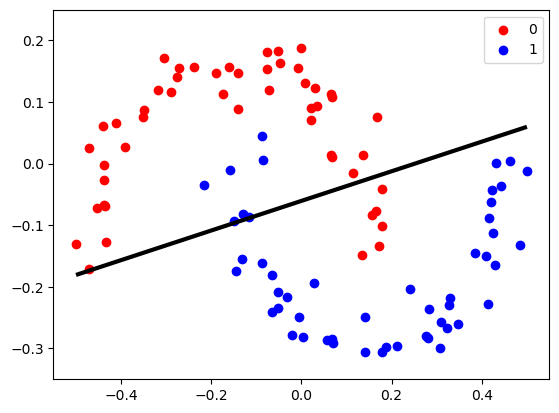

<Figure size 640x480 with 0 Axes>

In [30]:
p = np.linspace(-0.5, 0.5, 500)
x_plot, y_plot = np.meshgrid(p, p)
X_plot = np.stack((x_plot, y_plot), axis=2).reshape(-1, 2)
X_plot = torch.from_numpy(X_plot).float()
output = net(X_plot)
output = output.detach().numpy()
output = output.reshape(x_plot.shape[0], x_plot.shape[1])

plt.contour(x_plot, y_plot, output, [0.5],
                  colors=('k',),
                  linewidths=(3,))
plot(X0, X1)


### Implement your first multi-layer perceptron (MLP) for point cloud classification
Now you should notice that your logistic regression model cannot classify the point cloud correctly, and this is as expected :)  
Therefore, we now ask you to implement an MLP for the same binary classification task.

In [31]:
# These are the parameters to be used
nInput = 2
nOutput = 1
nHidden = 16
act_fn = nn.ReLU()

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nHidden, act_fn):
        super().__init__()

        # Define the network layers in order.
        # Input is 2D (nInput).
        # Output is a single value (nOutput).
        # Multiple linear layers each followed by a ReLU non-linearity (apart from the last).
        #########################################################################
        # TODO: add a two-layer MLP, inside the `nn.Sequential` call.
        # Input is 2D.
        # Output is a single value.

        # Hint: unlike logistic regression where you need only one nn.Linear layer, 
        # here you will have two nn.Linear layers. After the first layer, we 
        # apply a ReLU activation function. The output is then passed to another 
        # linear layer. Note that you should use `nHidden` below as the hidden dimension 
        # of your linear layers.
        #########################################################################
        self.model = nn.Sequential(
            nn.Linear(nInput, nHidden),
            act_fn,
            nn.Linear(nHidden, nOutput)
        )
        
    def forward(self, batch):
        # Process batch using the defined model.
        x = self.model(batch)
        # Final sigmoid activation to obtain a probability.
        return torch.sigmoid(x)


Run below again!

In [32]:
NUM_EPOCHS = 200

# create the network.
net = MLP(nInput, nOutput, nHidden, act_fn)

# create the optimizer.
optimizer = Adam(net.parameters(), lr=0.1)

best_accuracy = 0
for epoch_idx in range(NUM_EPOCHS):
    loss = train(net, optimizer, train_dataloader, epoch_idx)
    print('[Epoch %02d] Loss: %.4f' % (epoch_idx + 1, loss))

[Epoch 01] Loss: 6.6185
[Epoch 02] Loss: 4.0785
[Epoch 03] Loss: 3.6558
[Epoch 04] Loss: 3.7159
[Epoch 05] Loss: 3.8208
[Epoch 06] Loss: 3.6563
[Epoch 07] Loss: 4.8214
[Epoch 08] Loss: 3.4821
[Epoch 09] Loss: 3.4170
[Epoch 10] Loss: 3.2146
[Epoch 11] Loss: 3.5537
[Epoch 12] Loss: 3.3799
[Epoch 13] Loss: 3.4556
[Epoch 14] Loss: 3.8442
[Epoch 15] Loss: 3.4348
[Epoch 16] Loss: 3.7050
[Epoch 17] Loss: 2.9447
[Epoch 18] Loss: 3.1170
[Epoch 19] Loss: 2.8885
[Epoch 20] Loss: 3.1565
[Epoch 21] Loss: 3.0043
[Epoch 22] Loss: 3.2775
[Epoch 23] Loss: 3.1604
[Epoch 24] Loss: 2.9185
[Epoch 25] Loss: 2.9211
[Epoch 26] Loss: 2.9122
[Epoch 27] Loss: 3.0247
[Epoch 28] Loss: 3.0542
[Epoch 29] Loss: 3.1441
[Epoch 30] Loss: 2.8779
[Epoch 31] Loss: 2.9473
[Epoch 32] Loss: 2.9761
[Epoch 33] Loss: 2.9644
[Epoch 34] Loss: 2.9814
[Epoch 35] Loss: 3.0021
[Epoch 36] Loss: 3.0515
[Epoch 37] Loss: 3.4041
[Epoch 38] Loss: 2.9602
[Epoch 39] Loss: 3.3275
[Epoch 40] Loss: 3.3452
[Epoch 41] Loss: 3.4447
[Epoch 42] Loss:

Again plot your result. You should see that the decision boundary can clearly separate the point clouds.


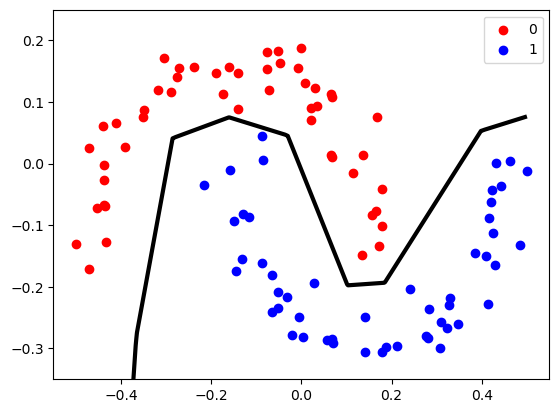

<Figure size 640x480 with 0 Axes>

In [33]:
p = np.linspace(-0.5, 0.5, 500)
x_plot, y_plot = np.meshgrid(p, p)
X_plot = np.stack((x_plot, y_plot), axis=2).reshape(-1, 2)
X_plot = torch.from_numpy(X_plot).float()
output = net(X_plot)
output = output.detach().numpy()
output = output.reshape(x_plot.shape[0], x_plot.shape[1])

plt.contour(x_plot, y_plot, output, [0.5],
                  colors=('k',),
                  linewidths=(3,))
plot(X0, X1)

When you are done, move forward to `image_classification.ipynb`.